## Calculating $d_{XY}$ in *Heliconius*

In [1]:
import numpy as np
import pysam
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from collections import Counter
import gzip

In [2]:
min_cnn = load_model('heliconius_cnn_min.mdl')
mean_cnn = load_model('heliconius_cnn_mean.mdl')
min_mean_cnn = load_model('heliconius_cnn_min-mean.mdl')
min_flagel = load_model('heliconius_flagel_min.mdl')
mean_flagel = load_model('heliconius_flagel_mean.mdl')

In [3]:
class HeliconiusPi():
    """
    Simple container class for storing relevant information for
    the Heliconius samples. Doesn't do anything fancy, just allows
    access to data.
    """

    def __init__(self):
        self.HeliconiusIdx = {
            'ama'  : [i for i in range(10)],
            'chi'  : [i for i in range(10,20)],
            'flo'  : [i for i in range(20,30)],
            'mal'  : [i for i in range(30,40)],
            'melG' : [i for i in range(40,50)],
            'num'  : [50,51],
            'ros'  : [i for i in range(52,62)],
            'txn'  : [i for i in range(62,72)],
            'vul'  : [i for i in range(72,82)],
            'zel'  : [i for i in range(82,92)],
            'melW' : [i for i in range(52,62)]+[i for i in range(72,82)],
            'melE' : [i for i in range(10)]+[i for i in range(30,40)],
            'cyd'  : [i for i in range(10,20)]+[i for i in range(82,92)],
            'tim'  : [i for i in range(20,30)]+[i for i in range(62,72)]
        }
        self.vcf_file = "heliconius_chr5.vcf.gz"
        self.vcf = pysam.VariantFile(self.vcf_file)
        print("Preparing to process vcf file {}".format(self.vcf_file))

    def __call__(self,p1,p2,p3):
        """
        Makes any instance of the class callable as a function, which
        does all of the sampling and returns an imput image.
        """
        pi_mat = np.zeros((950,6,2))
        windows = np.linspace(200000,9700000,950+1)
        p1_idx, p2_idx, p3_idx = self.get_random_idx(p1,p2,p3)
        print("Calculating pi for the following taxa:")
        print("  {}: individuals {}".format(p1, p1_idx))
        print("  {}: individuals {}".format(p2, p2_idx))
        print("  {}: individuals {}".format(p3, p3_idx))
        for w in range(950):
            gt = self.get_gts(windows[w],windows[w+1])
            #print(w,len(gt))
            _,pi_mat[w,0,0],pi_mat[w,0,1] = self.calc_pi(gt,p1_idx,p2_idx)
            _,pi_mat[w,1,0],pi_mat[w,1,1] = self.calc_pi(gt,p1_idx,p3_idx)
            _,pi_mat[w,2,0],pi_mat[w,2,1] = self.calc_pi(gt,p2_idx,p3_idx)
            _,pi_mat[w,3,0],pi_mat[w,3,1] = self.calc_pi(gt,p1_idx,self.HeliconiusIdx['num'])
            _,pi_mat[w,4,0],pi_mat[w,4,1] = self.calc_pi(gt,p2_idx,self.HeliconiusIdx['num'])
            _,pi_mat[w,5,0],pi_mat[w,5,1] = self.calc_pi(gt,p3_idx,self.HeliconiusIdx['num'])
            """
            pi_mat[w,0,0],pi_mat[w,0,1] = self.calc_pi(gt,self.HeliconiusIdx['p1'],self.HeliconiusIdx['p2'])
            pi_mat[w,1,0],pi_mat[w,1,1] = self.calc_pi(gt,self.HeliconiusIdx['p1'],self.HeliconiusIdx['p3'])
            pi_mat[w,2,0],pi_mat[w,2,1] = self.calc_pi(gt,self.HeliconiusIdx['p2'],self.HeliconiusIdx['p3'])
            pi_mat[w,3,0],pi_mat[w,3,1] = self.calc_pi(gt,self.HeliconiusIdx['p1'],self.HeliconiusIdx['out'])
            pi_mat[w,4,0],pi_mat[w,4,1] = self.calc_pi(gt,self.HeliconiusIdx['p1'],self.HeliconiusIdx['out'])
            pi_mat[w,5,0],pi_mat[w,5,1] = self.calc_pi(gt,self.HeliconiusIdx['p3'],self.HeliconiusIdx['out'])
            """
        return pi_mat

    def get_random_idx(self,p1,p2,p3):
        """
        Randomly sample 5 individuals from melW, melE, and cyd to calculate
        pairwise nucleotide diversity.
        """
        p1_idx = np.random.choice(self.HeliconiusIdx[p1], 5, replace=False)
        p2_idx = np.random.choice(self.HeliconiusIdx[p2], 5, replace=False)
        p3_idx = np.random.choice(self.HeliconiusIdx[p3], 5, replace=False)
        return (p1_idx,p2_idx,p3_idx)

    def get_gts(self,start,stop):
        """
        Retrieves the genotypes for all individuals within the window
        [start,stop). 0-indexed.
        """
        gts = []
        for rec in self.vcf.fetch('chr5',start-1,stop-1):
            gts.append([s['GT'] for s in rec.samples.values()])
        return gts

    def calc_pi(self,gt,idx1,idx2):
        """
        """
        def check_if_same(gt1,gt2):
            if gt1 is None or gt2 is None:
                return -9
            elif gt1 != gt2:
                return 1
            else:
                return 0
        pi_array = []
        nsnps = len(gt)
        for i in range(len(idx1)):
            for j in range(len(idx2)):
                pi_site = 0.0
                for l in range(nsnps):
                    if gt[l][idx1[i]][0] is None or gt[l][idx2[j]][0] is None:
                        continue
                    ct = Counter([gt[l][idx1[i]][0],gt[l][idx2[j]][0],gt[l][idx1[i]][1],gt[l][idx2[j]][1]])
                    x = list(ct.values())[0]
                    pi_site +=  x*(4.0-x)/12.0
                pi_array += [pi_site]
                """
                #print(idx1[i],idx2[j])
                pi_00 = np.array(
                    [check_if_same(gt[l][idx1[i]][0],gt[l][idx2[j]][0]) for l in range(nsnps)]
                )
                pi_01 = np.array(
                    [check_if_same(gt[l][idx1[i]][0],gt[l][idx2[j]][1]) for l in range(nsnps)]
                )
                pi_10 = np.array(
                    [check_if_same(gt[l][idx1[i]][1],gt[l][idx2[j]][0]) for l in range(nsnps)]
                )
                pi_11 = np.array(
                    [check_if_same(gt[l][idx1[i]][1],gt[l][idx2[j]][1]) for l in range(nsnps)]
                )
                pi_00,pi_01,pi_10,pi_11 = 0.0,0.0,0.0,0.0
                pi_tmp = 0.0
                none_counter = 0
                for l in range(nsnps):
                    if gt[l][idx1[i]][0] is None or gt[l][idx2[j]][0] is None:
                        none_counter += 1
                        continue
                    else:
                        #x_tmp = gt[l][idx1[i]][0] + gt[l][idx2[j]][0] + gt[l][idx1[i]][1] + gt[l][idx2[j]][1]
                        #pi_tmp += 2 * x_tmp * (4.0 - x_tmp) / 12.0
                        x_00  =  gt[l][idx1[i]][0] + gt[l][idx2[j]][0]
                        if x_00 * (2 - x_00) < 0:
                            print(gt[l][idx1[i]][0], gt[l][idx2[j]][0], x_00 * (2 - x_00), sep=',')
                        pi_00 += x_00 * (2 - x_00)
                        x_01  =  gt[l][idx1[i]][0] + gt[l][idx2[j]][1]
                        pi_01 += x_01 * (2 - x_01)
                        x_10  =  gt[l][idx1[i]][1] + gt[l][idx2[j]][0]
                        pi_10 += x_10 * (2 - x_10)
                        x_11  =  gt[l][idx1[i]][1] + gt[l][idx2[j]][1]
                        pi_11 += x_11 * (2 - x_11)
                
                pi_array += [
                    #np.sum(pi_00==1) / (nsnps - np.sum(pi_00==-9)) / 10000,
                    np.sum(pi_00==1) / 10000,
                    #np.sum(pi_01==1) / (nsnps - np.sum(pi_01==-9)) / 10000,
                    np.sum(pi_01==1) / 10000,
                    #np.sum(pi_10==1) / (nsnps - np.sum(pi_10==-9)) / 10000,
                    np.sum(pi_10==1) / 10000,
                    #np.sum(pi_11==1) / (nsnps - np.sum(pi_11==-9)) / 10000
                    np.sum(pi_11==1) / 10000
                ]
                """
        return (pi_array,np.min(pi_array),np.mean(pi_array))

In [4]:
hpi = HeliconiusPi()

Preparing to process vcf file heliconius_chr5.vcf.gz


In [12]:
mat = hpi('ama','ros','zel')

Calculating pi for the following taxa:
  ama: individuals [6 5 3 1 4]
  ros: individuals [55 60 57 59 56]
  zel: individuals [84 87 88 83 82]


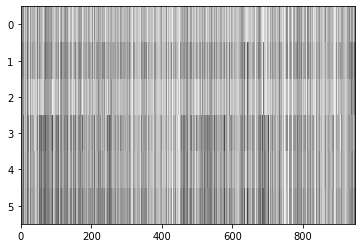

In [14]:
plt.imshow(mat[:,:,1].T/np.max(mat[:,:,1].T), aspect='auto', cmap='Greys')

In [5]:
triplets = [
    ['melG','ros','chi'],
    ['melG','ros','zel'],
    ['melG','vul','chi'],
    ['melG','vul','zel'],
    ['mal','ros','chi'],
    ['mal','ros','zel'],
    ['mal','vul','chi'],
    ['mal','vul','zel'],
    ['ama','ros','chi'],
    ['ama','ros','zel'],
    ['ama','vul','chi'],
    ['ama','vul','zel']
]
for t in triplets:
    print("Triplet {},{},{}:".format(t[0],t[1],t[2]))
    mat = hpi(t[0],t[1],t[2])
    print("    Avg. pi for min channel:  {}".format(np.mean(mat[:,:,0]/np.max(mat[:,:,0]),axis=0)))
    print("    Avg. pi for mean channel: {}".format(np.mean(mat[:,:,1]/np.max(mat[:,:,1]),axis=0)))
    min_dat = np.zeros((1,950,6,1))
    min_dat[0,:,:,0] = mat[:,:,0]/np.max(mat[:,:,0])
    mean_dat = np.zeros((1,950,6,1))
    mean_dat[0,:,:,0] = mat[:,:,1]/np.max(mat[:,:,1])
    min_mean_dat = np.zeros((1,950,6,2))
    min_mean_dat[0,:,:,0] = mat[:,:,0]/np.max(mat[:,:,0])
    min_mean_dat[0,:,:,1] = mat[:,:,1]/np.max(mat[:,:,1])
    min_dat_flagel = np.zeros((1,950,6))
    min_dat_flagel[0,:,:] = mat[:,:,0]/np.max(mat[:,:,0])
    mean_dat_flagel = np.zeros((1,950,6))
    mean_dat_flagel[0,:,:] = mat[:,:,1]/np.max(mat[:,:,1])
    print("  Prediction for min CNN:         {}".format(min_cnn.predict(min_dat)[0]))
    print("  Prediction for mean CNN:        {}".format(mean_cnn.predict(mean_dat)[0]))
    print("  Prediction for min-mean CNN:    {}".format(min_mean_cnn.predict(min_mean_dat)[0]))
    print("  Prediction for flagel-min CNN:  {}".format(min_flagel.predict(min_dat_flagel)[0]))
    print("  Prediction for flagel-mean CNN: {}\n".format(mean_flagel.predict(mean_dat_flagel)[0]))

Triplet melG,ros,chi:
Calculating pi for the following taxa:
  melG: individuals [44 46 47 43 45]
  ros: individuals [54 59 60 56 61]
  chi: individuals [13 16 14 12 17]
    Avg. pi for min channel:  [0.31574768 0.37566493 0.29525377 0.42091956 0.39628337 0.4335392 ]
    Avg. pi for mean channel: [0.38453104 0.43380558 0.36328546 0.46227058 0.44843411 0.46939972]
  Prediction for min CNN:         [7.1092181e-02 9.2890781e-01 3.3826776e-08]
  Prediction for mean CNN:        [1.01292106e-32 9.81787682e-01 1.82123668e-02]
  Prediction for min-mean CNN:    [1.3157656e-02 9.8680311e-01 3.9340790e-05]
  Prediction for flagel-min CNN:  [1.000000e+00 9.725259e-12 1.140089e-17]
  Prediction for flagel-mean CNN: [0.3313888  0.3341291  0.33448204]

Triplet melG,ros,zel:
Calculating pi for the following taxa:
  melG: individuals [41 47 43 44 46]
  ros: individuals [54 61 56 59 57]
  zel: individuals [90 89 83 87 84]
    Avg. pi for min channel:  [0.32814744 0.37937278 0.31612762 0.42381329 0.42467

    Avg. pi for min channel:  [0.36836093 0.40996455 0.34354556 0.45388792 0.45762642 0.4655575 ]
    Avg. pi for mean channel: [0.41361675 0.44241179 0.39186004 0.46289233 0.47342469 0.47240801]
  Prediction for min CNN:         [4.3046111e-01 5.6953895e-01 1.0551885e-08]
  Prediction for mean CNN:        [0.0000000e+00 9.9999964e-01 3.9009913e-07]
  Prediction for min-mean CNN:    [3.7397002e-03 9.9624819e-01 1.2133279e-05]
  Prediction for flagel-min CNN:  [1.0000000e+00 8.7998998e-14 9.7057754e-21]
  Prediction for flagel-mean CNN: [0.3313888  0.3341291  0.33448204]



In [42]:
np.mean(mat[:,:,0]/np.max(mat[:,:,0]),axis=0)

array([0.12877116, 0.19651365, 0.17715534, 0.31674928, 0.29814206,
       0.23689772])

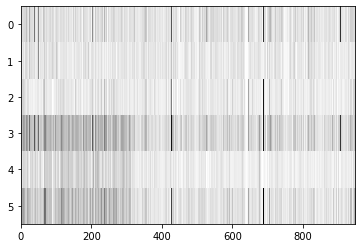

In [35]:
plt.imshow(mat[:,:,0].T/np.max(mat[:,:,0].T), aspect='auto', cmap='Greys')

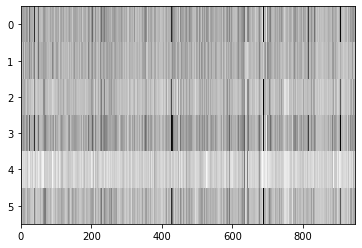

In [36]:
plt.imshow(mat[:,:,1].T/np.max(mat[:,:,1].T), aspect='auto', cmap='Greys')

In [32]:
min_dat = np.zeros((1,950,6,1))
min_dat[0,:,:,0] = mat[:,:,0]/np.max(mat[:,:,0])
mean_dat = np.zeros((1,950,6,1))
mean_dat[0,:,:,0] = mat[:,:,1]/np.max(mat[:,:,1])
min_mean_dat = np.zeros((1,950,6,2))
min_mean_dat[0,:,:,0] = mat[:,:,0]/np.max(mat[:,:,0])
min_mean_dat[0,:,:,1] = mat[:,:,1]/np.max(mat[:,:,1])
min_dat_flagel = np.zeros((1,950,6))
min_dat_flagel[0,:,:] = mat[:,:,0]/np.max(mat[:,:,0])

In [33]:
print("Prediction for min CNN: {}".format(min_cnn.predict(min_dat)[0]))
print("Prediction for mean CNN: {}".format(mean_cnn.predict(mean_dat)[0]))
print("Prediction for min-mean CNN: {}".format(min_mean_cnn.predict(min_mean_dat)[0]))
print("Prediction for flagel CNN: {}".format(min_flagel.predict(min_dat_flagel)[0]))

Prediction for min CNN: [6.3552916e-02 9.3643856e-01 8.6072387e-06]
Prediction for mean CNN: [4.1780905e-07 4.8915781e-02 9.5108384e-01]
Prediction for min-mean CNN: [0.08344247 0.00411797 0.9124396 ]
Prediction for flagel CNN: [9.9999833e-01 1.7080588e-06 8.7558705e-10]


In [7]:
min_cnn_res      = []
mean_cnn_res     = []
min_mean_cnn_res = []
min_flagel_res   = []
for i in range(100):
    mat = hpi('melE','melW','cyd')
    min_dat = np.zeros((1,950,6,1))
    min_dat[0,:,:,0] = mat[:,:,0]/np.max(mat[:,:,0])
    mean_dat = np.zeros((1,950,6,1))
    mean_dat[0,:,:,0] = mat[:,:,1]/np.max(mat[:,:,1])
    min_mean_dat = np.zeros((1,950,6,2))
    min_mean_dat[0,:,:,0] = mat[:,:,0]/np.max(mat[:,:,0])
    min_mean_dat[0,:,:,1] = mat[:,:,1]/np.max(mat[:,:,1])
    min_dat_flagel = np.zeros((1,950,6))
    min_dat_flagel[0,:,:] = mat[:,:,0]/np.max(mat[:,:,0])
    min_cnn_res.append(min_cnn.predict(min_dat)[0])
    mean_cnn_res.append(mean_cnn.predict(mean_dat)[0])
    min_mean_cnn_res.append(min_mean_cnn.predict(min_mean_dat)[0])
    min_flagel_res.append(min_flagel.predict(min_dat_flagel)[0])
    print('Finished iteration {}...'.format(i+1), flush=True)

Calculating pi for the following taxa:
  melE: individuals [31  8  1  4 33]
  melW: individuals [58 61 76 73 55]
  cyd: individuals [16 89 91 87 83]
Finished iteration 1...
Calculating pi for the following taxa:
  melE: individuals [35  1 32  2  3]
  melW: individuals [55 73 53 58 57]
  cyd: individuals [84 85 17 89 19]
Finished iteration 2...
Calculating pi for the following taxa:
  melE: individuals [ 5  8 36  1 32]
  melW: individuals [72 59 80 61 78]
  cyd: individuals [85 14 87 10 17]
Finished iteration 3...
Calculating pi for the following taxa:
  melE: individuals [36 32 33  1 31]
  melW: individuals [61 57 73 79 59]
  cyd: individuals [13 19 89 10 83]
Finished iteration 4...
Calculating pi for the following taxa:
  melE: individuals [ 5 38  0 31 32]
  melW: individuals [61 56 78 54 52]
  cyd: individuals [86 85 89 88 83]
Finished iteration 5...
Calculating pi for the following taxa:
  melE: individuals [38 32 37 34  0]
  melW: individuals [58 72 59 76 74]
  cyd: individuals [82

Finished iteration 48...
Calculating pi for the following taxa:
  melE: individuals [36  0 38 35  3]
  melW: individuals [75 59 54 53 57]
  cyd: individuals [10 19 89 87 85]
Finished iteration 49...
Calculating pi for the following taxa:
  melE: individuals [ 0  3 33 31  8]
  melW: individuals [56 55 52 57 61]
  cyd: individuals [88 84 83 15 18]
Finished iteration 50...
Calculating pi for the following taxa:
  melE: individuals [ 7 38  5 30 34]
  melW: individuals [55 58 81 77 74]
  cyd: individuals [15 86 82 83 16]
Finished iteration 51...
Calculating pi for the following taxa:
  melE: individuals [ 6 31 36 34  7]
  melW: individuals [81 78 73 72 80]
  cyd: individuals [19 87 88 83 17]
Finished iteration 52...
Calculating pi for the following taxa:
  melE: individuals [33 31  2  9 35]
  melW: individuals [73 79 80 72 59]
  cyd: individuals [88 89 12 19 11]
Finished iteration 53...
Calculating pi for the following taxa:
  melE: individuals [37  1  0 33 36]
  melW: individuals [61 56 55

Calculating pi for the following taxa:
  melE: individuals [34  1 37  4 35]
  melW: individuals [80 76 75 52 56]
  cyd: individuals [14 10 82 11 18]
Finished iteration 96...
Calculating pi for the following taxa:
  melE: individuals [ 6  1 38  7  0]
  melW: individuals [75 52 55 80 81]
  cyd: individuals [85 17 10 19 91]
Finished iteration 97...
Calculating pi for the following taxa:
  melE: individuals [ 1  7  5  9 38]
  melW: individuals [61 59 52 78 55]
  cyd: individuals [16 82 87 89 14]
Finished iteration 98...
Calculating pi for the following taxa:
  melE: individuals [ 5 31  8 35 34]
  melW: individuals [54 61 79 78 56]
  cyd: individuals [83 87 15 10 90]
Finished iteration 99...
Calculating pi for the following taxa:
  melE: individuals [38  9 39  6  3]
  melW: individuals [59 73 57 76 75]
  cyd: individuals [91 16 18 15 10]
Finished iteration 100...


In [8]:
print("Prediction for min CNN: {}".format(np.mean(np.array(min_cnn_res),axis=0)))
print("Prediction for mean CNN: {}".format(np.mean(np.array(mean_cnn_res),axis=0)))
print("Prediction for min-mean CNN: {}".format(np.mean(np.array(min_mean_cnn_res),axis=0)))
print("Prediction for flagel CNN: {}".format(np.mean(np.array(min_flagel_res),axis=0)))

Prediction for min CNN: [1.1472201e-01 8.8527811e-01 2.8110071e-08]
Prediction for mean CNN: [3.2329852e-29 9.8844892e-01 1.1551177e-02]
Prediction for min-mean CNN: [8.918177e-03 9.910500e-01 3.164173e-05]
Prediction for flagel CNN: [1.000000e+00 5.239816e-12 6.178252e-18]


In [9]:
np.savetxt("min_cnn_res.csv",np.array(min_cnn_res),delimiter=",")
np.savetxt("meann_cnn_res.csv",np.array(mean_cnn_res),delimiter=",")
np.savetxt("min_mean_cnn_res.csv",np.array(min_mean_cnn_res),delimiter=",")
np.savetxt("min_flagel_res.csv",np.array(min_flagel_res),delimiter=",")

In [7]:
gts = hpi.get_gts(200000,9700000)

In [8]:
taxa = ['ros','vul','mal','ama','melG','chi','zel','flo','txn','num']

In [ ]:
for k in taxa:
    for v in hpi.HeliconiusIdx[k]:
        none_count = 0
        for l in range(len(gts)):
            if gts[l][v][0] is None:
                none_count += 1
        print("Percent missing data for {}_{}: {}%".format(k,v,round(100.0*none_count/len(gts),2)))

In [7]:
for i in range(len(taxa)-1):
    for j in range(i,len(taxa)):
        print("{} x {}".format(taxa[i],taxa[j]))
        print(hpi.calc_pi(gts,hpi.HeliconiusIdx[taxa[i]],hpi.HeliconiusIdx[taxa[j]]))

ros x ros
(0.0, 6.4528039999999995)
ros x vul
(5.5455, 10.453174)
ros x mal
(4.3963, 8.463966000000001)
ros x ama
(3.3195, 7.662489999999999)
ros x melG
(3.7692, 7.760240000000001)
ros x chi
(4.9191, 9.935386000000001)
ros x zel
(4.1192, 8.238804)
ros x flo
(4.8734, 9.761735999999999)
ros x txn
(5.497, 10.664648)
ros x num
(6.626, 10.793380000000003)
vul x vul
(0.0, 6.116615999999999)
vul x mal
(5.3158, 9.768756000000002)
vul x ama
(5.3688, 10.374488)
vul x melG
(5.8758, 10.508858)
vul x chi
(4.3965, 9.134578)
vul x zel
(5.2854, 9.918076)
vul x flo
(4.3498, 8.784574000000001)
vul x txn
(3.1359, 7.113715999999999)
vul x num
(4.0458, 7.1716999999999995)
mal x mal
(0.0, 5.636166)
mal x ama
(4.3411, 8.541248)
mal x melG
(4.9208, 8.982004)
mal x chi
(5.2503, 10.00336)
mal x zel
(3.6546, 7.4202759999999985)
mal x flo
(5.2543, 9.80819)
mal x txn
(5.2745, 9.98414)
mal x num
(6.3348, 10.098139999999999)
ama x ama
(0.0, 6.824071999999998)
ama x melG
(3.9612, 8.170069999999999)
ama x chi
(4.7304,

In [64]:
def parse_gzvcf(gzvcf, start, stop):
    vcf_mat = []
    with gzip.open(gzvcf) as f:
        for line in f:
            line = line.decode()
            if line[0] == "#":
                continue
            else:
                tkns = line.strip().split()
                if int(tkns[1]) >= start and int(tkns[1]) < stop:
                    genotypes = [
                        (tkns[t].split("/")[0],tkns[t].split("/")[1]) for t in range(9,len(tkns))
                    ]
                    vcf_mat.append(genotypes)
                else:
                    continue
        return vcf_mat

In [66]:
def calc_pi2(gt,idx1,idx2):
    """
    """
    def check_if_same(gt1,gt2):
        if gt1 is None or gt2 is None:
            return -9
        elif gt1 != gt2:
            return 1
        else:
            return 0
    pi_array = []
    nsnps = len(gt)
    for i in range(len(idx1)):
        for j in range(len(idx2)):
            pi_site = 0.0
            for l in range(nsnps):
                if gt[l][idx1[i]][0] == '.' or gt[l][idx2[j]][0] == '.':
                    continue
                ct = Counter([gt[l][idx1[i]][0],gt[l][idx2[j]][0],gt[l][idx1[i]][1],gt[l][idx2[j]][1]])
                x = list(ct.values())[0]
                pi_site +=  x*(4.0-x)/12.0
            pi_array += [pi_site]
            """
            pi_00 = np.array(
                [check_if_same(gt[l][idx1[i]][0],gt[l][idx2[j]][0]) for l in range(nsnps)]
            )
            pi_01 = np.array(
                [check_if_same(gt[l][idx1[i]][0],gt[l][idx2[j]][1]) for l in range(nsnps)]
            )
            pi_10 = np.array(
                [check_if_same(gt[l][idx1[i]][1],gt[l][idx2[j]][0]) for l in range(nsnps)]
            )
            pi_11 = np.array(
                [check_if_same(gt[l][idx1[i]][1],gt[l][idx2[j]][1]) for l in range(nsnps)]
            )
            pi_array += [
                np.sum(pi_00==1) +
                np.sum(pi_01==1) +
                np.sum(pi_10==1) +
                np.sum(pi_11==1) / 4.0
            ]
            """
    return (pi_array,np.min(pi_array),np.mean(pi_array))

In [69]:
for l in range(500):
    print(gts[l][0],gts2[l][0])

(1, 1) ('1', '1')
(0, 0) ('0', '0')
(0, 0) ('0', '0')
(0, 0) ('0', '0')
(0, 1) ('0', '1')
(1, 1) ('1', '1')
(0, 0) ('0', '0')
(0, 0) ('0', '0')
(0, 0) ('0', '0')
(0, 0) ('0', '0')
(0, 0) ('0', '0')
(0, 0) ('0', '0')
(0, 0) ('0', '0')
(0, 0) ('0', '0')
(0, 0) ('0', '0')
(0, 0) ('0', '0')
(0, 0) ('0', '0')
(0, 1) ('0', '1')
(0, 0) ('0', '0')
(0, 0) ('0', '0')
(1, 1) ('1', '1')
(0, 0) ('0', '0')
(0, 0) ('0', '0')
(0, 0) ('0', '0')
(0, 0) ('0', '0')
(0, 0) ('0', '0')
(0, 0) ('0', '0')
(0, 0) ('0', '0')
(0, 0) ('0', '0')
(0, 0) ('0', '0')
(0, 0) ('0', '0')
(0, 0) ('0', '0')
(1, 1) ('1', '1')
(0, 0) ('0', '0')
(0, 1) ('0', '1')
(0, 0) ('0', '0')
(0, 0) ('0', '0')
(0, 1) ('0', '1')
(0, 0) ('0', '0')
(0, 0) ('0', '0')
(0, 0) ('0', '0')
(0, 0) ('0', '0')
(0, 0) ('0', '0')
(0, 0) ('0', '0')
(0, 0) ('0', '0')
(0, 0) ('0', '0')
(0, 0) ('0', '0')
(0, 0) ('0', '0')
(0, 0) ('0', '0')
(0, 0) ('0', '0')
(0, 0) ('0', '0')
(0, 0) ('0', '0')
(0, 0) ('0', '0')
(0, 0) ('0', '0')
(0, 1) ('0', '1')
(0, 0) ('0

In [67]:
calc_pi2(gts2,[0],[0])

([23269.666666653535], 23269.666666653535, 23269.666666653535)

In [65]:
gts2 = parse_gzvcf("heliconius_chr5.vcf.gz", 200000,9500000)

In [33]:
calc_pi2(gts2,hpi.HeliconiusIdx['ros'],hpi.HeliconiusIdx['tim'])
#plt.hist([t for t in taxon_pi if t != 0])

([18559.000000004005,
  19050.666666668883,
  19068.333333335486,
  18958.000000002554,
  19260.000000001455,
  18310.666666671576,
  18735.333333336697,
  18767.00000000325,
  18646.00000000369,
  18958.000000002554,
  18554.333333337356,
  19020.666666668993,
  19011.333333335693,
  18879.333333336173,
  19279.000000001386,
  18666.33333333695,
  19139.333333335228,
  19124.00000000195,
  19005.333333335715,
  19324.000000001222,
  18002.666666672696,
  18418.666666671183,
  18417.333333337854,
  18332.333333338163,
  18601.000000003853],
 18002.666666672696,
 18803.546666669783)

In [15]:
for t in taxa:
    taxon_pi = hpi.calc_pi(gts,hpi.HeliconiusIdx[t],hpi.HeliconiusIdx[t])[0]
    print("{} : {}".format(t, np.mean([tp for tp in taxon_pi if tp != 0])))

ros : 7.1697822222222225
vul : 6.796239999999999
mal : 6.262406666666667
ama : 7.5823022222222205
melG : 5.593528888888889
chi : 8.569986666666667
zel : 6.588313333333334
flo : 7.185304444444445
txn : 6.905306666666666
num : 4.8091


In [68]:
for i in range(len(taxa)-1):
    for j in range(i,len(taxa)):
        print("{} x {}".format(taxa[i],taxa[j]))
        print(calc_pi2(gts2,hpi.HeliconiusIdx[taxa[i]],hpi.HeliconiusIdx[taxa[j]]))

ros x ros
([23269.666666653535, 34889.41666665636, 35014.41666665546, 35113.416666656776, 33949.5833333211, 34889.41666665636, 23264.666666653553, 35078.74999999009, 35017.41666665651, 33781.74999998723, 35014.41666665546, 35078.74999999009, 23326.333333319995, 35230.08333332262, 34199.583333320974, 35113.416666656776, 35017.41666665651, 35230.08333332262, 23311.33333332005, 34019.24999998747, 33949.5833333211, 33781.74999998723, 34199.583333320974, 34019.24999998747, 22506.999999989643], 22506.999999989643, 32330.653333321843)
ros x vul
([44782.000000013155, 45114.00000001454, 45200.000000014195, 45261.666666680845, 45947.83333335001, 44444.250000013446, 44720.00000001416, 44812.08333334781, 44891.33333334782, 45596.66666668319, 44788.333333345865, 45162.41666668035, 45218.33333334714, 45266.00000001387, 46011.00000001641, 44876.33333334658, 45230.75000001462, 45233.25000001467, 45316.000000014494, 46029.00000001722, 43654.50000000985, 43938.50000001164, 44029.83333334489, 44112.50000

([32806.49999998214, 34332.74999998846, 32418.499999985554, 33963.74999998777, 33897.08333332114, 32889.66666664899, 34512.24999998908, 32625.833333318973, 34142.99999998818, 34068.58333332107, 33109.58333331637, 34724.41666665605, 32709.33333331844, 34356.16666665507, 34156.8333333215, 32988.24999998287, 34762.833333322735, 32639.83333331849, 34345.33333332161, 34182.41666665466, 33525.66666665143, 35199.74999998983, 33240.49999998611, 34831.66666665564, 34774.416666656136], 32418.499999985554, 33808.19666665353)
vul x num
([32106.999999985797, 32218.666666652323, 32461.49999998527, 32460.833333318922, 33056.166666652556], 32106.999999985797, 32460.833333318973)
mal x mal
([20222.66666666462, 30476.916666652724, 30451.16666665319, 30256.249999986936, 29288.666666654623, 30476.916666652724, 21306.333333327344, 30600.666666653236, 31314.83333331822, 29843.66666665426, 30451.16666665319, 30600.666666653236, 20744.999999996053, 31107.583333318606, 29882.99999998688, 30256.249999986936, 31

KeyboardInterrupt: 